In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint
# to persist the numpy arrays data
import h5py
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

print(tf.__version__)
df_ibuprofen = pd.read_csv('data/ibuprofen.csv')
print(df_ibuprofen.dtypes.value_counts())
print(df_ibuprofen.columns.tolist())
print('length of columns :', len(df_ibuprofen.columns.tolist()))
print(df_ibuprofen.count())
df_ibuprofen.head()

1.12.0
float64    2
int64      1
object     1
dtype: int64
['dateUnix', 'dateIso', 'kgPrice', 'quantity']
length of columns : 4
dateUnix    3978
dateIso     3978
kgPrice     3978
quantity    3978
dtype: int64


,dateUnix,dateIso,kgPrice,quantity
0,1483311600,1/1/2017,15.111767,20000.0
1,1483311600,1/1/2017,12.697010,3000.0
2,1483311600,1/1/2017,9.700000,6500.0
3,1483311600,1/1/2017,11.347700,4000.0
4,1483311600,1/1/2017,9.347750,1000.0


In [45]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
    # NORMALIZE DATASET
    d = dataset
    mi = np.min(dataset)
    ma = np.max(dataset)

    norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
    return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
    mi = min(old_data)
    ma = max(old_data)

    return ((val - a) * (ma-mi) / (b-a)) + mi

def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test
  
def get_data_dict(d_list, windows):
    length = len(d_list[0])
    step = 1
    forecast = 1

    _dict = {}
    for window in windows:
        X = []
        Y = []
        for i in range(0, length, step):
            try:
                # Get windowed data
                windowed_features_list = []
                for j in range(len(d_list)):
                    windowed_features_list.append(d_list[j][i:i+window])

                # ALWAYS TAKE THE FIRST data 
                y_i = d_list[0][i + window + forecast - 1] # indexing is important.
                x_i = np.column_stack(tuple(windowed_features_list))
            except Exception as e:
                print(e)
                break
            
            X.append(x_i)
            Y.append(y_i)
            #print(X)
        _dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
    return _dict

In [4]:
dataset = df_ibuprofen.copy()
dataset = dataset.drop("dateIso", axis=1)
dataset.head()

,dateUnix,kgPrice,quantity
0,1483311600,15.111767,20000.0
1,1483311600,12.697010,3000.0
2,1483311600,9.700000,6500.0
3,1483311600,11.347700,4000.0
4,1483311600,9.347750,1000.0


In [5]:
def fn(group):
    group['weighted_avg_kgprice'] = group['kgPrice'] * group['quantity'] / group['quantity'].sum()
    return group

d_agg = {'weighted_avg_kgprice':'sum', 
         'quantity':'sum'
        }

dataset_weighted = dataset.groupby('dateUnix', sort=False).apply(fn).groupby('dateUnix').agg(d_agg)
dataset_weighted.head()
#dataset_weighted

#print(dataset.groupby('dateUnix', sort=False).apply(fn))

,weighted_avg_kgprice,quantity
dateUnix,,
1483311600,12.405626,46350.0
1483398000,11.801926,2300.0
1483484400,11.687077,15550.0
1483657200,19.074012,9850.0
1483743600,13.525167,17850.0


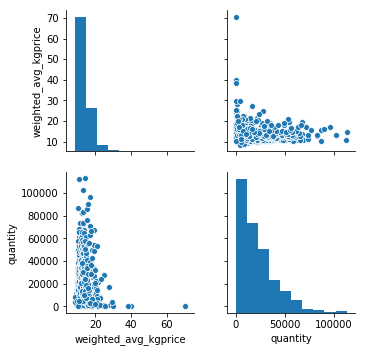

In [6]:
sns.pairplot(dataset_weighted)

In [7]:
ds = dataset_weighted.drop('quantity', 1)
ds.head()

,weighted_avg_kgprice
dateUnix,
1483311600,12.405626
1483398000,11.801926
1483484400,11.687077
1483657200,19.074012
1483743600,13.525167


In [8]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [9]:
window_size = 3
temps = pd.DataFrame(ds.values)
#print(temps)
datasetframe = create_window(temps, window_size)
print(datasetframe.head(5))
#dataframe

           0          0          0          0
0  12.405626  11.801926  11.687077  19.074012
1  11.801926  11.687077  19.074012  13.525167
2  11.687077  19.074012  13.525167  11.601642
3  19.074012  13.525167  11.601642  13.449941
4  13.525167  11.601642  13.449941   9.697000


In [28]:
def create_dataset_new(dataset, window=1):
    dataX, dataY = [], []
    for index, row in dataset.iterrows():
        a = row[0 : window]
        dataX.append(a)
        #print(row[-1:])
        dataY.append(row[-1:])
    return np.array(dataX), np.array(dataY)

features, labels = create_dataset_new(datasetframe, window_size)
features
print(features.shape)
#labels
print(labels.shape)

(601, 3)
(601, 1)


In [29]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state = 0, shuffle=False)
features_train
print(features_train.shape)
#labels_test
#print(labels_test.shape)

(540, 3)


In [30]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(features_train, (features_train.shape[0], features_train.shape[1], 1))
testX = np.reshape(features_test, (features_test.shape[0], features_test.shape[1], 1))
print(trainX.shape)
print(testX.shape)

(540, 3, 1)
(61, 3, 1)


In [31]:
w = 6
#w = 8
#w = 12
batch_size = 32

In [33]:

def build_model():
    #create model
    model = keras.Sequential()
    
    model.add(layers.LSTM(10, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(layers.LSTM(10, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(layers.LSTM(10, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model



In [34]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [36]:
checkpoint = ModelCheckpoint(filepath='models/ibuprofen_univariate_bidirlstm_model_price.h5', verbose=1, save_best_only=True)
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = model.fit(trainX, labels_train, epochs=1000, batch_size=32, verbose=0, callbacks=[early_stop, checkpoint], validation_split=0.1)


Epoch 00001: val_loss improved from inf to 57.31452, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00002: val_loss improved from 57.31452 to 54.70426, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00003: val_loss improved from 54.70426 to 52.24341, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00004: val_loss improved from 52.24341 to 49.77585, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00005: val_loss improved from 49.77585 to 47.39780, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00006: val_loss improved from 47.39780 to 45.07454, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00007: val_loss improved from 45.07454 to 42.87251, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00008: val_loss improved from 42.87251 to 40.76133, saving model to models/ibuprofen_univariate_bidirl


Epoch 00075: val_loss did not improve from 18.95975

Epoch 00076: val_loss improved from 18.95975 to 18.91145, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00077: val_loss did not improve from 18.91145

Epoch 00078: val_loss did not improve from 18.91145

Epoch 00079: val_loss did not improve from 18.91145

Epoch 00080: val_loss improved from 18.91145 to 18.84886, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00081: val_loss improved from 18.84886 to 18.78789, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00082: val_loss improved from 18.78789 to 18.74440, saving model to models/ibuprofen_univariate_bidirlstm_model_price.h5

Epoch 00083: val_loss did not improve from 18.74440

Epoch 00084: val_loss did not improve from 18.74440

Epoch 00085: val_loss did not improve from 18.74440

Epoch 00086: val_loss did not improve from 18.74440

Epoch 00087: val_loss did not improve from 18.74440

Epoch 0008


Epoch 00196: val_loss did not improve from 17.50593

Epoch 00197: val_loss did not improve from 17.50593

Epoch 00198: val_loss did not improve from 17.50593

Epoch 00199: val_loss did not improve from 17.50593

Epoch 00200: val_loss did not improve from 17.50593

Epoch 00201: val_loss did not improve from 17.50593

Epoch 00202: val_loss did not improve from 17.50593

Epoch 00203: val_loss did not improve from 17.50593

Epoch 00204: val_loss did not improve from 17.50593

Epoch 00205: val_loss did not improve from 17.50593

Epoch 00206: val_loss did not improve from 17.50593

Epoch 00207: val_loss did not improve from 17.50593

Epoch 00208: val_loss did not improve from 17.50593

Epoch 00209: val_loss did not improve from 17.50593

Epoch 00210: val_loss did not improve from 17.50593

Epoch 00211: val_loss did not improve from 17.50593

Epoch 00212: val_loss did not improve from 17.50593

Epoch 00213: val_loss did not improve from 17.50593

Epoch 00214: val_loss did not improve from 17

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
333,17.825791,2.607293,17.825791,11.153620,1.583933,11.153620,333
334,17.767152,2.603978,17.767152,11.144262,1.583531,11.144262,334
335,17.807385,2.606154,17.807385,11.146360,1.583954,11.146360,335
336,17.686479,2.600507,17.686479,11.137009,1.587050,11.137009,336
337,17.568705,2.598556,17.568705,11.153993,1.603578,11.153993,337


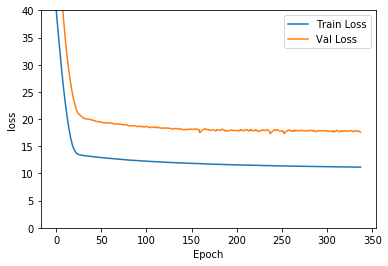

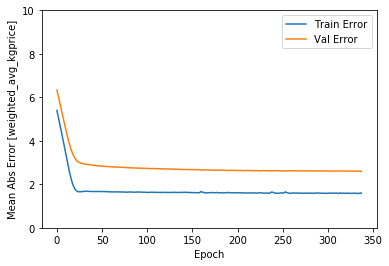

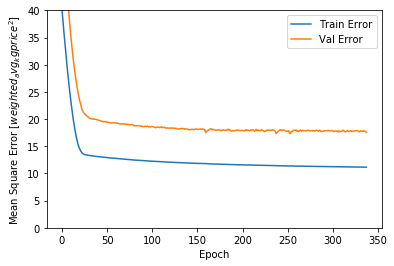

In [38]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.ylim([0, 40])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [weighted_avg_kgprice]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0, 10])
  plt.legend()
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$weighted_avg_kgprice^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0, 40])
  plt.legend()
  
  plt.show()


plot_history(history)

In [39]:
loss, mae, mse = model.evaluate(testX, labels_test, verbose=1)
print("loss: {:5.2f} ".format(loss))
print("mse: {:5.2f} ".format(mse))
print("Testing set Mean Abs Error: {:5.2f} weighted_avg_kgprice".format(mae))
#print(loss)

61/61 [==============================] - 0s 5ms/step
loss: 34.20 
mse: 34.20 
Testing set Mean Abs Error:  3.68 weighted_avg_kgprice


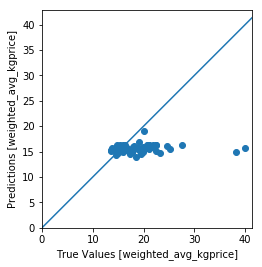

In [40]:
test_predictions = model.predict(testX).flatten()

plt.scatter(labels_test, test_predictions)
plt.xlabel('True Values [weighted_avg_kgprice]')
plt.ylabel('Predictions [weighted_avg_kgprice]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

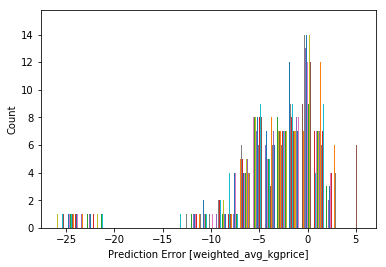

In [41]:
error = test_predictions - labels_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [weighted_avg_kgprice]")
_ = plt.ylabel("Count")

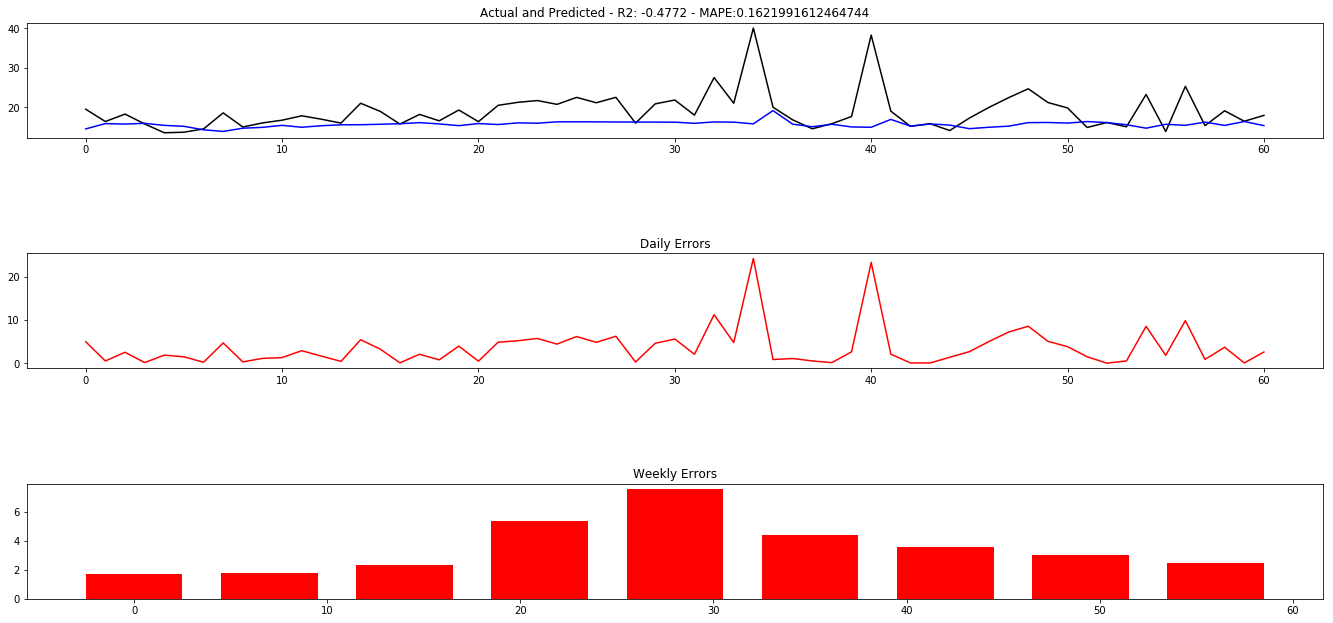

In [46]:
actual = []
#print(labels_test)
plot_prediction(labels_test, test_predictions)

In [47]:
test_predictions = model.predict(testX).flatten()
print("Predicted \t True value")
for x in range(0, len(test_predictions)):
  print("{:.3f} \t\t {:.3f}".format(test_predictions[x], labels_test[x][0])) 
  #print("True value: {}".format(labels_test.iloc[x])) 
#print(test_predictions)

Predicted 	 True value
14.515 		 19.488
15.855 		 16.380
15.733 		 18.263
15.921 		 15.767
15.401 		 13.534
15.168 		 13.672
14.284 		 14.507
13.873 		 18.567
14.684 		 14.991
14.901 		 16.024
15.413 		 16.718
14.927 		 17.826
15.319 		 16.964
15.549 		 15.980
15.571 		 21.000
15.686 		 18.944
15.829 		 15.733
16.096 		 18.174
15.773 		 16.558
15.333 		 19.287
15.867 		 16.345
15.618 		 20.478
16.032 		 21.228
15.952 		 21.688
16.296 		 20.723
16.304 		 22.484
16.291 		 21.126
16.261 		 22.500
16.250 		 15.971
16.233 		 20.843
16.219 		 21.822
15.921 		 17.996
16.277 		 27.503
16.223 		 21.001
15.788 		 40.035
19.145 		 20.000
15.716 		 16.809
15.061 		 14.537
15.685 		 15.833
15.007 		 17.648
14.925 		 38.246
16.914 		 19.008
15.221 		 15.158
15.766 		 15.825
15.476 		 14.098
14.570 		 17.249
14.929 		 19.960
15.203 		 22.420
16.102 		 24.660
16.136 		 21.193
15.981 		 19.812
16.367 		 14.876
16.107 		 16.122
15.571 		 15.043
14.695 		 23.226
15.679 		 13.847
15.420 		 25.276
16.224 	

In [97]:
#print(labels_test)